In [46]:
import sklearn
# import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Import base classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from baselines import AdaFairClassifier
from imbens.ensemble import SMOTEBoostClassifier, SMOTEBaggingClassifier, RUSBoostClassifier, UnderBaggingClassifier, SelfPacedEnsembleClassifier
from fairlearn.postprocessing import ThresholdOptimizer
from fairens import FairAugEnsemble, FairEnsemble

# Set GPU for matrix computations
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.set_device(0)
    device_id = torch.cuda.current_device()
    print (f"Now using GPU #{device_id}:\n{torch.cuda.get_device_name(device_id)}")

# Import utilities
from data import FairDataset    # This is a custom class that we will use to load the datasets
from eval import evaluate_multi_split, verbose_print
from trainer import Trainer
from utils import seed_generator, dict_info, describe_data

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[FairAdapt]'


Now using GPU #0:
Tesla V100-SXM2-32GB


# Load dataset


In [2]:
SEED = 42
n_splits = 5
i_split = 0

dataset_kwargs = {
    'y_col': 'label',
    'train_size': 0.6,
    'val_size': 0.2,
    'test_size': 0.2,
    'concat_train_val': True,
    'normalize': True,
    'random_state': 42,
}

dataname = 'adult'
s_attr = 'gender'
# dataname = 'compas'
# s_attr = 'sex'
data = FairDataset(
    dataname=dataname,
    csv_path=f'./data/{dataname}.csv',
    s_col=s_attr,
    x_with_s=True,
    **dataset_kwargs
)

data.describe()

(
    (X_train, y_train, s_train),
    (X_val, y_val, s_val),
    (X_test, y_test, s_test),
    (idx_train, idx_val, idx_test)
) = data.get_subgroup_split(i_split=i_split, random_state=SEED, n_splits=n_splits)

classes = np.unique(y_train)
n_feat = X_train.shape[1]
n_class = len(classes)

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : gender/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train data [#samples 36177 #features 98]:
+-----+-------+-------+------------+
|     |   y=0 |   y=1 |   pos_rate |
+=====+=======+=======+============+
| s=0 | 10421 |  1335 |     0.1136 |
+-----+-------+-------+------------+
| s=1 | 16790 |  7631 |     0.3125 |
+-----+-------+-------+------------+
test data [#samples 9045 #features 98]:
+-----+-------+-------+------------+
|     |   y=0 |   y=1 |   pos_rate |
+=====+=======+=======+============+
| s=0 |  2605 |   334 |     0.1136 |
+-----+-------+-------+------------+
| s=1 |  4198 |  1908 |     0.3125 |
+-----+-------+-------+------------+



In [3]:
from utils_unloc import DataProcessor

data_split_info = f"{data.fullname}_split[{i_split+1}of{n_splits}]_seed[{SEED}]"
print(f"data_split_info: {data_split_info}")

s_prv, s_prt = 1, 0

msk_prv, msk_prt = s_train == s_prv, s_train == s_prt
n_prv, n_prt = msk_prv.sum(), msk_prt.sum()
idx_prv, idx_prt = np.where(msk_prv)[0], np.where(msk_prt)[0]

X_prv, y_prv = X_train[idx_prv], y_train[idx_prv]
X_prt, y_prt = X_train[idx_prt], y_train[idx_prt]


dp = DataProcessor()

df_train = pd.DataFrame(X_train, columns=data.feature_names)
df_train = df_train.drop(data.s_col, axis=1)
idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train, verbose=True)
df_train_encoded, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train,  name_feats)
df_train_encoded


from utils_unloc import ComparableSampleAnalyzer

prox_kwargs = {
    't_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 
    'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
    'include_self': False
}

csa = ComparableSampleAnalyzer(
    df_train_encoded, feats_con, feats_cat, 
    save_path='data_cache', data_setting=data_split_info, 
    compress=False, verbose=True
)
P = csa.get_proximity(**prox_kwargs)

data_split_info: adult_gender_split[1of5]_seed[42]
////// Feature Numbers //////
Total:        97 
Continuous:   5  	 e.g., ['capital-gain', 'age', 'education-num', 'capital-loss', 'hours-per-week'] 
Categorical:  1  	 e.g., ['race'] 
One-hot:      91 	 e.g., ['workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc']
Raw one-hot:  6  	 e.g., ['education', 'marital-status', 'occupation', 'native-country', 'relationship']
Raw total:    12 
////// Comparable Analyzer //////
Data shape: (27133, 12)
[5] Continuous features: ['capital-gain', 'age', 'education-num', 'capital-loss', 'hours-per-week']
[7] Categorical features: ['race', 'education', 'marital-status', 'occupation', 'native-country', 'relationship', 'workclass']

Matrix loaded from data_cache/proximity/adult_gender_split[1of5]_seed[42]_TC=0.1_TD=2_RP=0.1_norm=sym_matrix.h5


In [4]:
from utils_unloc import DataProcessor, UnfairnessAttributer, ComparableSampleAnalyzer
from utils import generate_random_seeds

class UnLoc():
    
    def __init__(self) -> None:
        pass

    def _save_df(self, df, name, path='./data_cache/score'):
        df.to_csv(f"{path}/{name}.csv", index=False)

    def _load_df(self, name, path='./data_cache/score'):
        return pd.read_csv(f"{path}/{name}.csv")

    def compute_df_encoded(self, X, features, s_col):
        dp = DataProcessor()
        df_train_withs = pd.DataFrame(X, columns=features)
        idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train_withs, verbose=False)
        df_train_withs_nooh, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train_withs, name_feats, encode=False)
        self.df_train_withs = df_train_withs
        self.df_train_withs_nooh = df_train_withs_nooh
        self.name_feats_withs = name_feats
        
        # we dont use sensitive attribute for computing comparable samples
        df_train = pd.DataFrame(X, columns=features).drop(s_col, axis=1)
        idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train, verbose=False)
        df_train_encoded, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train, name_feats)

        self.df_train = df_train
        self.df_train_encoded = df_train_encoded
        self.feats_con = feats_con
        self.feats_cat = feats_cat
        self.name_feats = name_feats
        
    def fit_transform(self, X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=1, s_prt=0):
        # guarantee X's 1st column is sensitive attribute
        assert (X[:, 0] == s).all()
        
        file_name = f"{data_split_info}_{str(prox_kwargs)}_score"
        
        self.compute_df_encoded(X, features, s_col)

        try:
            df_score = self._load_df(file_name)
            print(f"Loaded score from {file_name}.csv")
            return df_score
        except:
            pass

        P = self.get_proximity(X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=s_prv, s_prt=s_prt)

        # compute confidence score
        attributer = UnfairnessAttributer(P)
        df_score = attributer.compute_confidence(X, y, s, s_prv=s_prv, s_prt=s_prt)

        # save df_score
        self._save_df(df_score, file_name)
        print(f"Saved score to {file_name}.csv")

        return df_score

    def get_proximity(self, X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=1, s_prt=0):
        
        df_train_encoded, feats_con, feats_cat = self.df_train_encoded, self.feats_con, self.feats_cat
        
        csa = ComparableSampleAnalyzer(
            df_train_encoded, feats_con, feats_cat, 
            save_path='data_cache', data_setting=data_split_info, 
            compress=False, verbose=True
        )
        P = csa.get_proximity(**prox_kwargs)
        return P
    

    def fair_aug(
        self, aug_ratio, X_train, y_train, s_train, P, 
        s_prv=1, s_prt=0, filter=None, weights=None, dummy=False, random_seed=None, verbose=False
    ):
        if aug_ratio == 0:
            return X_train, y_train, s_train, 0
        
        if filter is not None:
            if filter == 'prt-pos':
                mask_seeds = (y_train == 1) & (s_train == s_prt)
            elif filter == 'pos':
                mask_seeds = (y_train == 1)
            else:
                raise NotImplementedError
        else: mask_seeds = np.ones(len(y_train), dtype=bool)
        
        if weights is None or dummy:
            weights = np.ones(len(y_train), dtype=float)
        else:
            assert weights.shape == y_train.shape

        seed_weights = weights[mask_seeds]
        seed_weights /= seed_weights.sum()
        
        # compute n aug
        n_aug = int(aug_ratio * len(seed_weights))
        
        # sample seeds
        idx_seeds = np.where(mask_seeds)[0]
        np.random.seed(random_seed)
        idx_aug_seeds = np.random.choice(
            idx_seeds, n_aug, p=seed_weights, replace=True
        )

        random_seeds = generate_random_seeds(n_aug, random_seed)

        X_new, y_new, s_new = [], [], []

        for i, idx_seed in enumerate(idx_aug_seeds):
            rand_seed = random_seeds[i]
            idx_mixup = get_mixup_idx(
                idx_seed, P, y_train, s_train,
                group_constraint='same', label_constraint='diff', 
                top_n=10, random_seed=rand_seed
            )
            _, x_new_input = mixup_instance(
                idx_seed, idx_mixup, 
                self.df_train_withs_nooh, 
                self.df_train_withs, 
                self.name_feats_withs, 
                seed=rand_seed
            )
            X_new.append(x_new_input)
            y_new.append(y_train[idx_seed])
            s_new.append(s_train[idx_seed])
        
        X_edited = np.concatenate([X_train, np.array(X_new)], axis=0)
        y_edited = np.concatenate([y_train, np.array(y_new)], axis=0)
        s_edited = np.concatenate([s_train, np.array(s_new)], axis=0)
        
        if verbose:
            print(
                f"{len(y_edited) - len(y_train)} samples added from the dataset.\n"
                f"Dataset shape: {X_train.shape} -> {X_edited.shape}\n"
                f"S distribution {np.unique(s_train, return_counts=True)} -> {np.unique(s_edited, return_counts=True)}\n"
                f"Y distribution {np.unique(y_train, return_counts=True)} -> {np.unique(y_edited, return_counts=True)}"
            )

        return X_edited, y_edited, s_edited, n_aug
        

    def fair_removal(
        self, X_train, y_train, s_train, weights, edit_ratio, how='removal',
        s_prv=1, s_prt=0, filter=None, verbose=False, dummy=False, random_state=42,
    ):
        # Sort indices by descending weights
        sorted_indices = np.argsort(weights)[::-1]

        if filter is not None:
            if filter == 'prt-neg':
                filter_idx = (y_train[sorted_indices] == 0) & (s_train[sorted_indices] == s_prt)
            elif filter == 'prv-pos':
                filter_idx = (y_train[sorted_indices] == 1) & (s_train[sorted_indices] == s_prv)
            elif filter == 'prt-neg-prv-pos':
                filter_idx = ((y_train[sorted_indices] == 0) & (s_train[sorted_indices] == s_prt)) | ((y_train[sorted_indices] == 1) & (s_train[sorted_indices] == s_prv))
            elif filter == 'prv':
                filter_idx = (s_train[sorted_indices] == s_prv)
            elif filter == 'prt':
                filter_idx = (s_train[sorted_indices] == s_prt)
            elif filter == 'neg':
                filter_idx = (y_train[sorted_indices] == 0)
            elif filter == 'pos':
                filter_idx = (y_train[sorted_indices] == 1)
            else:
                raise NotImplementedError

            sorted_indices = sorted_indices[filter_idx]
        
        n_edit = int(edit_ratio * len(sorted_indices))
        # select the removal indices
        edit_indices = sorted_indices[:n_edit]

        if dummy:
            # set seed
            np.random.seed(random_state)
            edit_indices = np.random.choice(sorted_indices, n_edit, replace=False)
        else:
            edit_indices = sorted_indices[:n_edit]
        
        # Create edit mask
        if how == 'removal':
            keep_mask = np.ones(len(X_train), dtype=bool)
            keep_mask[edit_indices] = False
            # Apply undersampled mask
            X_edited = X_train[keep_mask]
            y_edited = y_train[keep_mask]
            s_edited = s_train[keep_mask]
        elif how == 'relabel':
            relabel_mask = np.zeros(len(X_train), dtype=bool)
            relabel_mask[edit_indices] = True
            y_edited = y_train.copy()
            y_edited[relabel_mask] = 1 - y_edited[relabel_mask]
            X_edited = X_train
            s_edited = s_train
        else: raise NotImplementedError
        
        if verbose:
            print(
                f"{len(y_train) - len(y_edited)} samples removed from the dataset.\n"
                f"Dataset shape: {X_train.shape} -> {X_edited.shape}\n"
                f"S distribution {np.unique(s_train, return_counts=True)} -> {np.unique(s_edited, return_counts=True)}\n"
                f"Y distribution {np.unique(y_train, return_counts=True)} -> {np.unique(y_edited, return_counts=True)}"
            )
        return X_edited, y_edited, s_edited, n_edit

# prox_kwargs = {
#     't_con': 0.1, 't_cat': 1, 'restart_prob': 0.1, 'mat_norm': 'sym', 
#     'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
#     'include_self': False
# }

AIM = UnLoc()
df_score = AIM.fit_transform(X_train, y_train, s_train, data_split_info, data.feature_names, data.s_col, prox_kwargs)
df_score

Loaded score from adult_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


,conf,unf,unf_contr
0,0.939018,0.002154,0.027044
1,0.493721,0.304229,0.142366
2,0.451387,0.881193,0.043696
3,0.842168,0.044978,0.067009
4,0.948066,0.000001,0.000064
...,...,...,...
27128,0.987164,0.005077,0.271993
27129,0.991309,0.000237,0.004012
27130,0.980403,0.014899,0.075762
27131,0.897880,0.013478,0.730388


In [5]:
df_score.values[378]

array([0.57381396, 0.85816126, 2.26349872])

In [6]:
C = csa.get_comparable_matrix(t_con=0.1, t_cat=1)

Threshold for continuous features:  0.1
Threshold for categorical features: 1
Diff matrices loaded from data_cache/diff/adult_gender_split[1of5]_seed[42]_diff_matrices.h5
Time for computing continuous condition matrix: 1.02s
Time for computing categorical condition matrix: 1.05s
Linking isolated nodes (2148) ... Done! 0 remains.


In [7]:
unf_score, conf_score = df_score['unf'].values, df_score['conf'].values
unf_score

array([0.00215414, 0.30422896, 0.88119338, ..., 0.01489934, 0.01347767,
       0.00631102])

In [8]:
P_cumsum = np.cumsum(np.sort(P / P.sum(axis=1, keepdims=True), axis=1)[:, ::-1], axis=1)
P_cumsum

KeyboardInterrupt: 

In [ ]:
G = csa.get_gower_matrix()
PG = 1 / G
# PG = 1 - G
np.fill_diagonal(PG, 0)
PG = pd.DataFrame(PG).fillna(0).values
PG

ua = UnfairnessAttributer(PG)
df_score_gower = ua.compute_confidence(X_train, y_train, s_train, visualize=False)

In [ ]:
msk_prt_neg = (y_train == 0) & (s_train == s_prt)
msk_have_comparable = C.sum(axis=1) >= 3
msk_dense_explanable = P_cumsum[:, 5] > 0.9
msk_fairness = unf_score > 0.8
msk_target = msk_prt_neg & msk_dense_explanable & msk_fairness & msk_have_comparable

print (f"Number of target samples: {msk_target.sum()}")

idx_target = np.where(msk_target)[0]

i = idx_target[0]
print(i, unf_score[i])

def get_support_raw_features(df_raw, P, C, G, df_score, y, s, i, k=10, grp_cst='na', label_cst='na'):
    sim_idx = np.argsort(P[i])[::-1]

    if grp_cst == 'same':
        sim_idx = sim_idx[s[sim_idx] == s[i]]
    elif grp_cst == 'diff':
        sim_idx = sim_idx[s[sim_idx] != s[i]]
    elif grp_cst != 'na':
        raise NotImplementedError
    
    if label_cst == 'same':
        sim_idx = sim_idx[y[sim_idx] == y[i]]
    elif label_cst == 'diff':
        sim_idx = sim_idx[y[sim_idx] != y[i]]
    elif label_cst != 'na':
        raise NotImplementedError
    # remove i in sim_idx
    sim_idx = sim_idx[sim_idx != i][:k]

    # all_sim_score = P[i] / P[i].sum()
    # sim_score = np.concatenate([['self'], all_sim_score[sim_idx]])
    sim_score = P[i][sim_idx] / P[i][sim_idx].sum()
    sim_score = np.concatenate([['self'], sim_score])
    sim_idx_with_i = np.concatenate([[i], sim_idx])
    distance = G[i, sim_idx_with_i]
    com_score = C[i, sim_idx_with_i]
    df_sim = df_raw.iloc[sim_idx_with_i]
    df_sim['sim_score'] = sim_score
    df_sim['distance'] = distance
    df_sim['comparable?'] = com_score
    df_sim['bias'] = df_score['unf'].values[sim_idx_with_i]
    df_sim['conf'] = df_score['conf'].values[sim_idx_with_i]
    return df_sim

# get_support_raw_features(df_train_raw, P, C, G, df_score, y_train, s_train, i, k=5, grp_cst='diff', label_cst='na')

In [ ]:
# get_support_raw_features(df_train_raw, PG, C, G, df_score_gower, y_train, s_train, i, k=10, grp_cst='diff', label_cst='na')

# create counter factual by flipping label and observe bais score delta

In [ ]:
SEED = 42
n_splits = 5
i_split = 0

dataset_kwargs = {
    'y_col': 'label',
    'train_size': 0.6,
    'val_size': 0.2,
    'test_size': 0.2,
    'concat_train_val': True,
    'normalize': True,
    'random_state': 42,
}

# dataname = 'adult'
# s_attr = 'gender'
dataname = 'compas'
s_attr = 'sex'
data = FairDataset(
    dataname=dataname,
    csv_path=f'./data/{dataname}.csv',
    s_col=s_attr,
    x_with_s=True,
    **dataset_kwargs
)

data.describe()

(
    (X_train, y_train, s_train),
    (X_val, y_val, s_val),
    (X_test, y_test, s_test),
    (idx_train, idx_val, idx_test)
) = data.get_subgroup_split(i_split=i_split, random_state=SEED, n_splits=n_splits)

classes = np.unique(y_train)
n_feat = X_train.shape[1]
n_class = len(classes)

In [ ]:
from utils_unloc import DataProcessor

data_split_info = f"{data.fullname}_split[{i_split+1}of{n_splits}]_seed[{SEED}]"
print(f"data_split_info: {data_split_info}")

s_prv, s_prt = 1, 0

msk_prv, msk_prt = s_train == s_prv, s_train == s_prt
n_prv, n_prt = msk_prv.sum(), msk_prt.sum()
idx_prv, idx_prt = np.where(msk_prv)[0], np.where(msk_prt)[0]

X_prv, y_prv = X_train[idx_prv], y_train[idx_prv]
X_prt, y_prt = X_train[idx_prt], y_train[idx_prt]


dp = DataProcessor()

df_train = pd.DataFrame(X_train, columns=data.feature_names)
df_train = df_train.drop(data.s_col, axis=1)
idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train, verbose=True)
df_train_encoded, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train,  name_feats)
df_train_encoded


from utils_unloc import ComparableSampleAnalyzer

prox_kwargs = {
    't_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 
    'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
    'include_self': False
}

csa = ComparableSampleAnalyzer(
    df_train_encoded, feats_con, feats_cat, 
    save_path='data_cache', data_setting=data_split_info, 
    compress=False, verbose=True
)
P_org = csa.get_proximity(**prox_kwargs)

G = csa.get_gower_matrix()
PG = 1 / G
# PG = 1 - G
np.fill_diagonal(PG, 0)
P_gower = pd.DataFrame(PG).fillna(0).values

P_org, P_gower

In [ ]:
X, y, s = X_train, y_train, s_train
attributer_org = UnfairnessAttributer(P_org)
df_score = attributer_org.compute_confidence(X, y, s, s_prv=s_prv, s_prt=s_prt, visualize=True)

attributer_gower = UnfairnessAttributer(P_gower)
# df_score_gower = attributer_gower.compute_confidence(X, y, s, s_prv=s_prv, s_prt=s_prt, visualize=True)

In [ ]:
threshold = 0.5

fair_msk = (df_score_gower['unf'] < threshold) & (df_score['unf'] < threshold)
fair_idx = np.where(fair_msk)[0]
print (fair_msk.sum())

disag_score = df_score['unf'].values

disag_delta = (1-disag_score) - disag_score
# sns.histplot(disag_delta[(y==0) & (s==0)], bins=50)
sns.histplot(disag_delta[fair_msk], bins=50)
print(f"{disag_delta[fair_msk].mean():.4f} +/- {disag_delta[fair_msk].std():.4f}")
plt.show()

disag_score = df_score_gower['unf'].values

disag_delta = (1-disag_score) - disag_score
# sns.histplot(disag_delta[(y==0) & (s==0)], bins=50)
sns.histplot(disag_delta[fair_msk], bins=50)
print(f"{disag_delta[fair_msk].mean():.4f} +/- {disag_delta[fair_msk].std():.4f}")
plt.show()

In [ ]:
import tqdm

ds = []
for i in tqdm.tqdm(fair_idx):
    y_ = y.copy()
    y_[i] = 1 - y_[i]
    df_score_ = attributer_org.compute_confidence(X, y_, s, s_prv=s_prv, s_prt=s_prt)
    d = df_score_['unf'][i] - df_score['unf'][i]
    ds.append(d)

sns.histplot(ds, bins=50)
plt.show()

# Remove n samples and observe unfairness drop

In [13]:
"""Load Datasets"""

dataset_kwargs = {
    'y_col': 'label',
    'train_size': 0.6,
    'val_size': 0.2,
    'test_size': 0.2,
    'concat_train_val': True,
    'normalize': True,
    'random_state': 42,
}

all_datasets = {
    # 'compas': ['sex'],
    'compas': ['sex', 'race'],
    'adult': ['gender', 'race'],
    'bank': ['age', 'marital=married'],
    'lsa': ['gender', 'race'],
    'meps': ['SEX', 'RACE'],
    # 'lsa_unfair_gender_race': ['gender', 'race'],
}

"""
Create a dictionary of datasets: dataset_zoo
key: dataset name
value: FairDataset object
"""
dataset_zoo = {}
for dataname, s_attrs in all_datasets.items():
    for s_attr in s_attrs:
        dataset = FairDataset(
            dataname=dataname,
            csv_path=f'./data/{dataname}.csv',
            s_col=s_attr,
            **dataset_kwargs
        )
        dataset_zoo[dataset.fullname] = dataset

        # dataset.describe()
        dataset.brief()

# Print the information of the datasets and models
print(
    f"////// Dataset ZOO //////\n"
    f"{dict_info(dataset_zoo)}\n"
)

# dataset_zoo_subset = {
#     'compas_sex': dataset_zoo['compas_sex'],
#     'compas_race': dataset_zoo['compas_race'],
# }

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : sex/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 929, 1: 3771} | grp_pos_ratio: {0: 0.3617, 1: 0.4916}
test       | size {0: 232, 1: 943} | grp_pos_ratio: {0: 0.3621, 1: 0.491}

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : race/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 1878, 1: 2822} | grp_pos_ratio: {0: 0.3946, 1: 0.5135}
test       | size {0: 469, 1: 706} | grp_pos_ratio: {0: 0.3945, 1: 0.5127}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : gender/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 11756, 1: 24421} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}
test       | size {0: 2939, 1: 6106} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : race/labe

In [14]:
import tqdm
from sklearn.base import clone
from eval import evaluate

def run_unloc_remove_relabel_exp(
        unloc, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, prox_kwargs, how,
        n_splits=5, n_runs=1, random_state=42, verbose=False
):
    print(
        f"////// Baseline Experiment //////\n"
        f"Base Model Zoo:       {list(base_model_zoo.keys())}\n"
        f"Dataset Zoo:          {list(dataset_zoo.keys())}\n"
        f"edit_ratio_space:     {edit_ratio_space}\n"
        # f"setting_space:        {setting_space}\n"
        f"n_splits:             {n_splits}\n"
        f"n_runs:               {n_runs}\n"
        f"random_state:         {random_state}\n"
    )
    
    all_res = []

    for data_name, data in dataset_zoo.items():

        for base_model_name, base_model in base_model_zoo.items():

            for i_run in range(n_runs):

                print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name}")
                rand_seed = random_state + i_run

                base_model = base_model.set_params(random_state=rand_seed)
                
                for i_split in range(n_splits):
                    
                    print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name} | split {i_split}")
                    
                    # get the i-th split of a n-fold cross validation
                    (
                        (X_train, y_train, s_train),
                        (X_val, y_val, s_val),
                        (X_test, y_test, s_test),
                        (idx_train, idx_val, idx_test)
                    ) = data.get_subgroup_split(
                        i_split=i_split, 
                        random_state=rand_seed,
                        n_splits=n_splits
                    )
                    
                    data_split_info = f"{data.fullname}_split[{i_split+1}of{n_splits}]_seed[{rand_seed}]"
                    AIM = UnLoc()
                    df_score = AIM.fit_transform(
                        X_train, y_train, s_train, data_split_info, 
                        features=data.feature_names, 
                        s_col=data.s_col,
                        prox_kwargs=prox_kwargs,
                    )

                    for setting_name, setting_kwargs in setting_space.items():
                            
                        weights = df_score[setting_kwargs['weights']]
                        dummy = setting_kwargs['dummy']
                        f = setting_kwargs['filter']

                        for edit_ratio in tqdm.tqdm(edit_ratio_space, disable=verbose, desc=f"{setting_name} - n_edit"):

                            X_edited, y_edited, s_edited, n_edit = AIM.fair_removal(
                                X_train, y_train, s_train,
                                how=how,
                                edit_ratio=edit_ratio,
                                weights=weights,
                                dummy=dummy,
                                filter=f, 
                                verbose=False
                            )
                            
                            clf = clone(base_model)
                            clf.set_params(random_state=rand_seed)
                            clf.fit(X_edited, y_edited)
                            
                            res = evaluate(clf, X_test, y_test, s_test)
                            
                            all_res.append({
                                **res,
                                'how': how,
                                'setting': setting_name,
                                'n_edit': n_edit,
                                'edit_ratio': edit_ratio,
                                'dataset': data_name,
                                'base_model': base_model_name,
                                'i_run': i_run,
                                'i_split': i_split,
                            })
                            if verbose:
                                res_vis = res.copy()
                                for k, v in res_vis.items():
                                    if isinstance(v, float):
                                        res_vis[k] = np.round(v*100, 2)
                                print (f"split: {i_split} | n_edit {n_edit} | {res_vis}")
        
    df_res = pd.DataFrame(all_res)
    
    return df_res        


base_model_zoo = {
    'LR': LogisticRegression(),
    # 'KN': KNeighborsClassifier(n_neighbors=5),
    # 'DT': DecisionTreeClassifier(max_depth=10),
    # 'MLP': MLPClassifier(hidden_layer_sizes=(8), max_iter=50),
    # 'ADA': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
    # 'BAG': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
}
# n_space = np.linspace(0, 5000, 21).astype(int)
edit_ratio_space = np.linspace(0, 0.5, 26)
setting_space = setting_space = {
    'rand_prtneg': {'dummy': True, 'filter': 'prt-neg', 'weights': 'unf'},
    'disag_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf'},
    # 'disag_contr_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf_contr'},
    'rand': {'dummy': True, 'filter': None, 'weights': 'unf'},
    'disag': {'dummy': False, 'filter': None, 'weights': 'unf'},
}
prox_kwargs = {
    't_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 
    'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
    'include_self': False
}
n_splits = 5
n_runs = 1
random_state = 42
verbose = False
how = 'removal'

unloc = UnLoc()

df_res = run_unloc_remove_relabel_exp(
    unloc, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, 
    prox_kwargs=prox_kwargs, how=how, 
    n_splits=n_splits, n_runs=n_runs, random_state=random_state, verbose=verbose
)
df_res

////// Baseline Experiment //////
Base Model Zoo:       ['LR']
Dataset Zoo:          ['compas_sex', 'compas_race', 'adult_gender', 'adult_race', 'bank_age', 'bank_marital=married', 'lsa_gender', 'lsa_race', 'meps_SEX', 'meps_RACE']
edit_ratio_space:     [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]
n_splits:             5
n_runs:               1
random_state:         42

Data: compas_sex | Run: 0 | Base: LR
Data: compas_sex | Run: 0 | Base: LR | split 0
Loaded score from compas_sex_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit:   0%|          | 0/26 [00:00<?, ?it/s]

disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 17.74it/s]


Data: compas_sex | Run: 0 | Base: LR | split 1
Loaded score from compas_sex_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 16.01it/s]


Data: compas_sex | Run: 0 | Base: LR | split 2
Loaded score from compas_sex_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 16.42it/s]


Data: compas_sex | Run: 0 | Base: LR | split 3
Loaded score from compas_sex_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 16.78it/s]


Data: compas_sex | Run: 0 | Base: LR | split 4
Loaded score from compas_sex_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 21.16it/s]


Data: compas_race | Run: 0 | Base: LR
Data: compas_race | Run: 0 | Base: LR | split 0
Loaded score from compas_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 20.55it/s]


Data: compas_race | Run: 0 | Base: LR | split 1
Loaded score from compas_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 17.93it/s]


Data: compas_race | Run: 0 | Base: LR | split 2
Loaded score from compas_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 17.21it/s]


Data: compas_race | Run: 0 | Base: LR | split 3
Loaded score from compas_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:01<00:00, 17.39it/s]


Data: compas_race | Run: 0 | Base: LR | split 4
Loaded score from compas_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:02<00:00, 11.10it/s]


Data: adult_gender | Run: 0 | Base: LR
Data: adult_gender | Run: 0 | Base: LR | split 0
Loaded score from adult_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  3.11it/s]


Data: adult_gender | Run: 0 | Base: LR | split 1
Loaded score from adult_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  2.92it/s]


Data: adult_gender | Run: 0 | Base: LR | split 2
Loaded score from adult_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  2.99it/s]


Data: adult_gender | Run: 0 | Base: LR | split 3
Loaded score from adult_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:09<00:00,  2.84it/s]


Data: adult_gender | Run: 0 | Base: LR | split 4
Loaded score from adult_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]


Data: adult_race | Run: 0 | Base: LR
Data: adult_race | Run: 0 | Base: LR | split 0
Loaded score from adult_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  3.02it/s]


Data: adult_race | Run: 0 | Base: LR | split 1
Loaded score from adult_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Data: adult_race | Run: 0 | Base: LR | split 2
Loaded score from adult_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Data: adult_race | Run: 0 | Base: LR | split 3
Loaded score from adult_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.46it/s]


Data: adult_race | Run: 0 | Base: LR | split 4
Loaded score from adult_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:08<00:00,  2.99it/s]


Data: bank_age | Run: 0 | Base: LR
Data: bank_age | Run: 0 | Base: LR | split 0
Loaded score from bank_age_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


Data: bank_age | Run: 0 | Base: LR | split 1
Loaded score from bank_age_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Data: bank_age | Run: 0 | Base: LR | split 2
Loaded score from bank_age_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Data: bank_age | Run: 0 | Base: LR | split 3
Loaded score from bank_age_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  4.57it/s]


Data: bank_age | Run: 0 | Base: LR | split 4
Loaded score from bank_age_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Data: bank_marital=married | Run: 0 | Base: LR
Data: bank_marital=married | Run: 0 | Base: LR | split 0
Loaded score from bank_marital=married_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 1
Loaded score from bank_marital=married_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 2
Loaded score from bank_marital=married_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 3
Loaded score from bank_marital=married_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 4
Loaded score from bank_marital=married_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  4.70it/s]


Data: lsa_gender | Run: 0 | Base: LR
Data: lsa_gender | Run: 0 | Base: LR | split 0
Loaded score from lsa_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 1
Loaded score from lsa_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 2
Loaded score from lsa_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 3
Loaded score from lsa_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 4
Loaded score from lsa_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


Data: lsa_race | Run: 0 | Base: LR
Data: lsa_race | Run: 0 | Base: LR | split 0
Loaded score from lsa_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.63it/s]


Data: lsa_race | Run: 0 | Base: LR | split 1
Loaded score from lsa_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


Data: lsa_race | Run: 0 | Base: LR | split 2
Loaded score from lsa_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


Data: lsa_race | Run: 0 | Base: LR | split 3
Loaded score from lsa_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]


Data: lsa_race | Run: 0 | Base: LR | split 4
Loaded score from lsa_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


Data: meps_SEX | Run: 0 | Base: LR
Data: meps_SEX | Run: 0 | Base: LR | split 0
Loaded score from meps_SEX_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  5.66it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 1
Loaded score from meps_SEX_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 2
Loaded score from meps_SEX_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 3
Loaded score from meps_SEX_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:03<00:00,  8.51it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 4
Loaded score from meps_SEX_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  6.14it/s]


Data: meps_RACE | Run: 0 | Base: LR
Data: meps_RACE | Run: 0 | Base: LR | split 0
Loaded score from meps_RACE_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  6.10it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 1
Loaded score from meps_RACE_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 2
Loaded score from meps_RACE_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:02<00:00,  9.08it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 3
Loaded score from meps_RACE_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 4
Loaded score from meps_RACE_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag - n_edit: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s]


,acc,bacc,ap,roc,f1,dp,eo,ge,si,acc_grp,...,g_adv,acc_cls,how,setting,n_edit,edit_ratio,dataset,base_model,i_run,i_split
0,0.694468,0.690494,0.606229,0.690494,0.691027,0.361539,0.436371,0.164382,0.214468,"{0: 0.69, 1: 0.696}",...,1,"{0: 0.75, 1: 0.631}",removal,rand_prtneg,0,0.00,compas_sex,LR,0,0
1,0.693617,0.689697,0.605367,0.689697,0.690222,0.357228,0.436371,0.164586,0.211915,"{0: 0.685, 1: 0.696}",...,1,"{0: 0.748, 1: 0.631}",removal,rand_prtneg,8,0.02,compas_sex,LR,0,0
2,0.692766,0.688899,0.604509,0.688899,0.689418,0.352918,0.436371,0.164788,0.207660,"{0: 0.681, 1: 0.696}",...,1,"{0: 0.746, 1: 0.631}",removal,rand_prtneg,17,0.04,compas_sex,LR,0,0
3,0.693617,0.690042,0.605175,0.690042,0.690549,0.331366,0.400657,0.163044,0.198298,"{0: 0.685, 1: 0.696}",...,1,"{0: 0.743, 1: 0.637}",removal,rand_prtneg,26,0.06,compas_sex,LR,0,0
4,0.691064,0.687649,0.602626,0.687649,0.688128,0.318435,0.400657,0.163627,0.188085,"{0: 0.672, 1: 0.696}",...,1,"{0: 0.738, 1: 0.637}",removal,rand_prtneg,35,0.08,compas_sex,LR,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,0.858857,0.642437,0.335903,0.642437,0.675718,0.067202,0.085225,0.080619,0.001895,"{0: 0.889, 1: 0.805}",...,1,"{0: 0.972, 1: 0.313}",removal,disag,3991,0.42,meps_RACE,LR,0,4
5196,0.858225,0.640596,0.333193,0.640596,0.673555,0.068185,0.085701,0.081044,0.004105,"{0: 0.889, 1: 0.803}",...,1,"{0: 0.972, 1: 0.309}",removal,disag,4181,0.44,meps_RACE,LR,0,4
5197,0.857910,0.640405,0.332309,0.640405,0.673185,0.069069,0.085701,0.081217,0.004105,"{0: 0.889, 1: 0.802}",...,1,"{0: 0.971, 1: 0.309}",removal,disag,4371,0.46,meps_RACE,LR,0,4
5198,0.858541,0.641516,0.334548,0.641516,0.674638,0.067694,0.081764,0.080831,0.003473,"{0: 0.889, 1: 0.803}",...,1,"{0: 0.972, 1: 0.311}",removal,disag,4561,0.48,meps_RACE,LR,0,4


In [ ]:
# df_res.to_csv(f"./res_cache/explanation_removal.csv", index=False)

In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df_res = pd.read_csv(f"./res_cache/explanation_removal.csv")

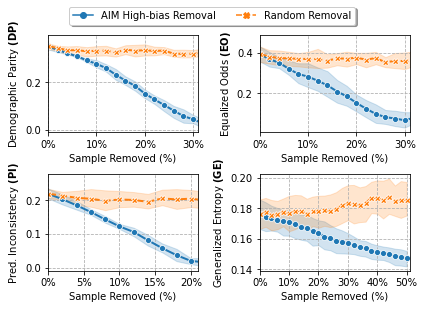

In [230]:
datasets_plot = [
    'compas_sex', 
    # 'compas_race', 
    # 'adult_gender', 
    # 'adult_race', 
    # 'bank_age', 
    # 'bank_marital=married', 
    # 'lsa_gender', 
    # 'lsa_race',
    # 'meps_SEX',
    # 'meps_RACE',
]
setting_plot = [
    # 'rand_prtneg',
    'disag_prtneg',
    'rand',
    # 'disag',
]

# only keep dataset within the datasets_plot
df_res_plot = df_res[df_res['dataset'].isin(datasets_plot)]
df_res_plot = df_res_plot[df_res_plot['setting'].isin(setting_plot)]
df_res_plot['pc'] = 1 - df_res_plot['si']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 4))

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='dp', hue='setting', style='setting', 
    markers=True, ax=ax1, lw=2,
)
ax.legend().set_visible(False)
# set the x-axis as percent
xlim = 0.31
xticks = np.arange(0, xlim, 0.1)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Sample Removed (%)',
    # ylabel='Demographic Parity',
    ylabel=r'Demographic Parity $\mathbf{(DP)}$',
    xlim=(0, xlim),
)

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='eo', hue='setting', style='setting', 
    markers=True, ax=ax2, lw=2, legend=False
)
# set the x-axis as percent
xlim = 0.31
xticks = np.arange(0, xlim, 0.1)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Sample Removed (%)',
    # ylabel='Equalized Odds',
    ylabel=r'Equalized Odds $\mathbf{(EO)}$',
    xlim=(0, xlim),
)

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='si', hue='setting', style='setting', 
    markers=True, ax=ax3, lw=2, 
    legend=False
)
# set x-axis as percent
xlim = 0.21
xticks = np.arange(0, xlim, 0.05)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Sample Removed (%)',
    # ylabel='Predictive Inconsistency',
    ylabel=r'Pred. Inconsistency $\mathbf{(PI)}$',
    xlim=(0, xlim),
)

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='ge', hue='setting', style='setting', 
    markers=True, ax=ax4, lw=2, 
    legend=False
)
# set x-axis as percent
xlim = 0.51
xticks = np.arange(0, xlim, 0.1)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Sample Removed (%)',
    # ylabel='Generalized Entropy',
    ylabel=r'Generalized Entropy $\mathbf{(GE)}$',
    xlim=(0, xlim),
)

# Get the legend handles
handles, labels = ax1.get_legend_handles_labels()
# Change the legend labels to "A" and "B"
new_labels = ['AIM High-bias Removal', 'Random Removal']
legend = fig.legend(
    handles, new_labels, 
    # title='Method',
    loc='upper center', bbox_to_anchor=(0.5, 1.08), 
    fancybox=True, shadow=True, ncol=10
)

plt.tight_layout()
plt.savefig(f'./figs/att_removal.png', bbox_inches='tight', pad_inches=.02, dpi=300)
plt.show()

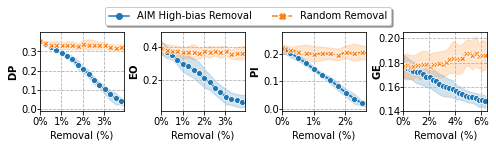

In [100]:
datasets_plot = [
    'compas_sex', 
    # 'compas_race', 
    # 'adult_gender', 
    # 'adult_race', 
    # 'bank_age', 
    # 'bank_marital=married', 
    # 'lsa_gender', 
    # 'lsa_race',
    # 'meps_SEX',
    # 'meps_RACE',
]

dataset_plot = 'compas_sex'
setting_plot = [
    # 'rand_prtneg',
    'disag_prtneg',
    'rand',
    # 'disag',
]


prtneg_ratio = {
    'compas_sex': 0.12595744680851065,
}

# only keep dataset within the datasets_plot
df_res = pd.read_csv(f"./res_cache/explanation_removal.csv")
df_res_plot = df_res[df_res['dataset'].isin([dataset_plot])]
df_res_plot = df_res_plot[df_res_plot['setting'].isin(setting_plot)]
df_res_plot['pc'] = 1 - df_res_plot['si']
df_res_plot['edit_ratio'] = df_res_plot['edit_ratio'] * prtneg_ratio[dataset_plot]

fig, axs = plt.subplots(1, 4, figsize=(7, 1.8))

ax = axs[0]

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='dp', hue='setting', style='setting', 
    markers=True, ax=ax, lw=2,
)
ax.legend().set_visible(False)
# set the x-axis as percent
xlim = 0.31 * prtneg_ratio[dataset_plot]
xticks = np.arange(0, xlim, 0.01)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ylims = ax.get_ylim()
yticks = np.arange(max(ylims[0], 0), ylims[1], 0.1)
ylabels = ['{:.1f}'.format(y) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.grid(ls='--')
ax.set(
    xlabel='Removal (%)',
    # ylabel='Demographic Parity',
    # ylabel='Demographic\nParity $\mathbf{(DP)}$',
    # ylabel=r'Demographic Parity $\mathbf{(DP)}$',
    ylabel=r'$\mathbf{DP}$',
    # ylabel=None, title='$\mathbf{DP}$',
    xlim=(0, xlim),
)

ax = axs[1]

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='eo', hue='setting', style='setting', 
    markers=True, ax=ax, lw=2, legend=False
)
# set the x-axis as percent
xlim = 0.31 * prtneg_ratio[dataset_plot]
xticks = np.arange(0, xlim, 0.01)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Removal (%)',
    # ylabel='Equalized Odds',
    # ylabel='Equalized \nOdds $\mathbf{(EO)}$',
    # ylabel=r'Equalized Odds $\mathbf{(EO)}$',
    ylabel=r'$\mathbf{EO}$',
    # ylabel=None, title='$\mathbf{EO}$',
    xlim=(0, xlim),
)

ax = axs[2]

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='si', hue='setting', style='setting', 
    markers=True, ax=ax, lw=2, 
    legend=False
)
# set x-axis as percent
xlim = 0.21 * prtneg_ratio[dataset_plot]
xticks = np.arange(0, xlim, 0.01)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.grid(ls='--')
ax.set(
    xlabel='Removal (%)',
    # ylabel='Predictive Inconsistency',
    # ylabel='Predictive\nInconsist. $\mathbf{(PI)}$',
    # ylabel=r'Pred. Inconsistency $\mathbf{(PI)}$',
    ylabel=r'$\mathbf{PI}$',
    # ylabel=None, title='$\mathbf{PI}$',
    xlim=(0, xlim),
)

ax = axs[3]

ax = sns.lineplot(
    data=df_res_plot, 
    x='edit_ratio', y='ge', hue='setting', style='setting', 
    markers=True, ax=ax, lw=2, 
    legend=False
)
# set x-axis as percent
xlim = 0.51 * prtneg_ratio[dataset_plot]
xticks = np.arange(0, xlim, 0.02)
xlabels = ['{:,.0%}'.format(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ylims = ax.get_ylim()
yticks = np.arange(ylims[0], ylims[1], 0.02)
ylabels = ['{:.2f}'.format(y) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.grid(ls='--')
ax.set(
    xlabel='Removal (%)',
    # ylabel='Generalized\nEntropy $\mathbf{(GE)}$',
    # ylabel=r'Generalized Entropy $\mathbf{(GE)}$',
    ylabel='$\mathbf{GE}$',
    # ylabel=None, title='$\mathbf{GE}$',
    xlim=(0, xlim),
)

# Get the legend handles
handles, labels = axs[0].get_legend_handles_labels()
# Change the legend labels to "A" and "B"
new_labels = ['AIM High-bias Removal', 'Random Removal']
legend = fig.legend(
    handles, new_labels, 
    # title='Method',
    loc='upper center', bbox_to_anchor=(0.5, 1.15), 
    fancybox=True, shadow=True, ncol=10
)

for ax in axs:
    ytick_labels = ax.get_yticklabels()
    for label in ytick_labels:
        label.set_x(0.05)
    xtick_labels = ax.get_xticklabels()
    for label in xtick_labels:
        label.set_y(0.02)
    ax.yaxis.set_label_coords(-0.25,0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.45, hspace=0.2)
plt.savefig(f'./figs/att_removal.png', bbox_inches='tight', pad_inches=.02, dpi=300)
plt.show()

# Predict dataset unfairness level 

In [74]:
from data import FairDataset

"""Load Datasets"""

dataset_kwargs = {
    'y_col': 'label',
    'train_size': 0.6,
    'val_size': 0.2,
    'test_size': 0.2,
    'concat_train_val': True,
    'normalize': True,
    'random_state': 42,
}

all_datasets = {
    'compas': ['sex', 'race'],
    'adult': ['gender', 'race'],
    'bank': ['age', 'marital=married'],
    'lsa': ['gender', 'race'],
    'meps': ['SEX', 'RACE'],
    # 'compas': ['race'],
    # 'adult': ['race'],
    # 'bank': ['marital=married'],
    # 'lsa': ['race'],
    # 'meps': ['RACE'],
}

"""
Create a dictionary of datasets: dataset_zoo
key: dataset name
value: FairDataset object
"""
dataset_zoo = {}
for dataname, s_attrs in all_datasets.items():
    for s_attr in s_attrs:
        dataset = FairDataset(
            dataname=dataname,
            csv_path=f'./data/{dataname}.csv',
            s_col=s_attr,
            **dataset_kwargs
        )
        dataset_zoo[dataset.fullname] = dataset

        # dataset.describe()
        dataset.brief()

# Print the information of the datasets and models
# print(
#     f"////// Dataset ZOO //////\n"
#     f"{dict_info(dataset_zoo)}\n"
# )

# dataset_zoo_subset = {
#     'compas_sex': dataset_zoo['compas_sex'],
#     'compas_race': dataset_zoo['compas_race'],
# }

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : sex/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 929, 1: 3771} | grp_pos_ratio: {0: 0.3617, 1: 0.4916}
test       | size {0: 232, 1: 943} | grp_pos_ratio: {0: 0.3621, 1: 0.491}

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : race/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 1878, 1: 2822} | grp_pos_ratio: {0: 0.3946, 1: 0.5135}
test       | size {0: 469, 1: 706} | grp_pos_ratio: {0: 0.3945, 1: 0.5127}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : gender/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 11756, 1: 24421} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}
test       | size {0: 2939, 1: 6106} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : race/labe

In [76]:
import tqdm
from sklearn.base import clone
from eval import evaluate

def run_AIM_remove_relabel_exp(
        AIM, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, prox_kwargs, how,
        n_splits=5, n_runs=1, random_state=42, verbose=False
):
    print(
        f"////// Baseline Experiment //////\n"
        f"Base Model Zoo:       {list(base_model_zoo.keys())}\n"
        f"Dataset Zoo:          {list(dataset_zoo.keys())}\n"
        f"edit_ratio_space:     {edit_ratio_space}\n"
        # f"setting_space:        {setting_space}\n"
        f"n_splits:             {n_splits}\n"
        f"n_runs:               {n_runs}\n"
        f"random_state:         {random_state}\n"
    )
    
    all_res = []

    for data_name, data in dataset_zoo.items():

        for base_model_name, base_model in base_model_zoo.items():

            for i_run in range(n_runs):

                print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name}")
                rand_seed = random_state + i_run

                base_model = base_model.set_params(random_state=rand_seed)
                
                for i_split in range(n_splits):
                    
                    print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name} | split {i_split}")
                    
                    # get the i-th split of a n-fold cross validation
                    (
                        (X_train, y_train, s_train),
                        (X_val, y_val, s_val),
                        (X_test, y_test, s_test),
                        (idx_train, idx_val, idx_test)
                    ) = data.get_subgroup_split(
                        i_split=i_split, 
                        random_state=rand_seed,
                        n_splits=n_splits
                    )
                    
                    data_split_info = f"{data.fullname}_split[{i_split+1}of{n_splits}]_seed[{rand_seed}]"
                    AIM = UnLoc()
                    df_score = AIM.fit_transform(
                        X_train, y_train, s_train, data_split_info, 
                        features=data.feature_names, 
                        s_col=data.s_col,
                        prox_kwargs=prox_kwargs,
                    )

                    for setting_name, setting_kwargs in setting_space.items():
                            
                        weights = df_score[setting_kwargs['weights']]
                        dummy = setting_kwargs['dummy']
                        f = setting_kwargs['filter']

                        for edit_ratio in tqdm.tqdm(edit_ratio_space, disable=verbose, desc=f"{setting_name} - n_edit"):

                            X_edited, y_edited, s_edited, n_edit = AIM.fair_removal(
                                X_train, y_train, s_train,
                                how=how,
                                edit_ratio=edit_ratio,
                                weights=weights,
                                dummy=dummy,
                                filter=f, 
                                verbose=False
                            )
                            
                            clf = clone(base_model)
                            clf.set_params(random_state=rand_seed)
                            clf.fit(X_edited, y_edited)
                            
                            res = evaluate(clf, X_test, y_test, s_test)
                            
                            all_res.append({
                                **res,
                                # 'pred_unf': df_score['unf'].values.sum(),
                                'pred_unf': df_score['unf'].values.mean(),
                                'pred_unf_ratio': (df_score['unf'] > 0.5).mean(),
                                'how': how,
                                'setting': setting_name,
                                'n_edit': n_edit,
                                'dataset': data_name,
                                'base_model': base_model_name,
                                'i_run': i_run,
                                'i_split': i_split,
                            })
                            if verbose:
                                res_vis = res.copy()
                                for k, v in res_vis.items():
                                    if isinstance(v, float):
                                        res_vis[k] = np.round(v*100, 2)
                                print (f"split: {i_split} | n_edit {n_edit} | {res_vis}")
        
    df_res = pd.DataFrame(all_res)
    
    return df_res        

from unloc import UnLoc
from sklearn.linear_model import LogisticRegression

base_model_zoo = {
    'LR': LogisticRegression(),
    # 'KN': KNeighborsClassifier(n_neighbors=5),
    # 'DT': DecisionTreeClassifier(max_depth=10),
    # 'MLP': MLPClassifier(hidden_layer_sizes=(8), max_iter=50),
    # 'ADA': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
    # 'BAG': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
}
# n_space = np.linspace(0, 5000, 21).astype(int)
edit_ratio_space = np.linspace(0, 0.0, 1)
setting_space = setting_space = {
    # 'rand_prtneg': {'dummy': True, 'filter': 'prt-neg', 'weights': 'unf'},
    # 'disag_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf'},
    # 'disag_contr_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf_contr'},
    'rand_prtneg': {'dummy': True, 'filter': None, 'weights': 'unf'},
    # 'disag_prtneg': {'dummy': False, 'filter': None, 'weights': 'unf'},
}
prox_kwargs = {
    't_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 
    'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
    'include_self': False
}
n_splits = 5
n_runs = 1
random_state = 42
verbose = False
how = 'removal'

aim = UnLoc()

df_res = run_AIM_remove_relabel_exp(
    aim, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, 
    prox_kwargs=prox_kwargs, how=how, 
    n_splits=n_splits, n_runs=n_runs, random_state=random_state, verbose=verbose
)
df_res.to_csv(f"./res_cache/att_dataset.csv", index=False)
# df_res

////// Baseline Experiment //////
Base Model Zoo:       ['LR']
Dataset Zoo:          ['compas_sex', 'compas_race', 'adult_gender', 'adult_race', 'bank_age', 'bank_marital=married', 'lsa_gender', 'lsa_race', 'meps_SEX', 'meps_RACE']
edit_ratio_space:     [0.]
n_splits:             5
n_runs:               1
random_state:         42

Data: compas_sex | Run: 0 | Base: LR
Data: compas_sex | Run: 0 | Base: LR | split 0
Loaded score from compas_sex_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit:   0%|          | 0/1 [00:00<?, ?it/s]

rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Data: compas_sex | Run: 0 | Base: LR | split 1
Loaded score from compas_sex_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

Data: compas_sex | Run: 0 | Base: LR | split 2


Loaded score from compas_sex_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Data: compas_sex | Run: 0 | Base: LR | split 3
Loaded score from compas_sex_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

Data: compas_sex | Run: 0 | Base: LR | split 4


Loaded score from compas_sex_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]

Data: compas_race | Run: 0 | Base: LR
Data: compas_race | Run: 0 | Base: LR | split 0


Loaded score from compas_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

Data: compas_race | Run: 0 | Base: LR | split 1


Loaded score from compas_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Data: compas_race | Run: 0 | Base: LR | split 2
Loaded score from compas_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]

Data: compas_race | Run: 0 | Base: LR | split 3


Loaded score from compas_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Data: compas_race | Run: 0 | Base: LR | split 4
Loaded score from compas_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Data: adult_gender | Run: 0 | Base: LR
Data: adult_gender | Run: 0 | Base: LR | split 0
Loaded score from adult_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Data: adult_gender | Run: 0 | Base: LR | split 1
Loaded score from adult_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Data: adult_gender | Run: 0 | Base: LR | split 2
Loaded score from adult_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Data: adult_gender | Run: 0 | Base: LR | split 3
Loaded score from adult_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Data: adult_gender | Run: 0 | Base: LR | split 4
Loaded score from adult_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Data: adult_race | Run: 0 | Base: LR
Data: adult_race | Run: 0 | Base: LR | split 0
Loaded score from adult_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Data: adult_race | Run: 0 | Base: LR | split 1
Loaded score from adult_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Data: adult_race | Run: 0 | Base: LR | split 2
Loaded score from adult_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Data: adult_race | Run: 0 | Base: LR | split 3
Loaded score from adult_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Data: adult_race | Run: 0 | Base: LR | split 4
Loaded score from adult_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Data: bank_age | Run: 0 | Base: LR
Data: bank_age | Run: 0 | Base: LR | split 0
Loaded score from bank_age_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Data: bank_age | Run: 0 | Base: LR | split 1
Loaded score from bank_age_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Data: bank_age | Run: 0 | Base: LR | split 2
Loaded score from bank_age_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Data: bank_age | Run: 0 | Base: LR | split 3
Loaded score from bank_age_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Data: bank_age | Run: 0 | Base: LR | split 4
Loaded score from bank_age_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Data: bank_marital=married | Run: 0 | Base: LR
Data: bank_marital=married | Run: 0 | Base: LR | split 0
Loaded score from bank_marital=married_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 1
Loaded score from bank_marital=married_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 2
Loaded score from bank_marital=married_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 3
Loaded score from bank_marital=married_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 4
Loaded score from bank_marital=married_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Data: lsa_gender | Run: 0 | Base: LR
Data: lsa_gender | Run: 0 | Base: LR | split 0
Loaded score from lsa_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 1
Loaded score from lsa_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 2
Loaded score from lsa_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 3
Loaded score from lsa_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 4
Loaded score from lsa_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Data: lsa_race | Run: 0 | Base: LR
Data: lsa_race | Run: 0 | Base: LR | split 0
Loaded score from lsa_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Data: lsa_race | Run: 0 | Base: LR | split 1
Loaded score from lsa_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Data: lsa_race | Run: 0 | Base: LR | split 2
Loaded score from lsa_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Data: lsa_race | Run: 0 | Base: LR | split 3
Loaded score from lsa_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Data: lsa_race | Run: 0 | Base: LR | split 4
Loaded score from lsa_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Data: meps_SEX | Run: 0 | Base: LR
Data: meps_SEX | Run: 0 | Base: LR | split 0
Loaded score from meps_SEX_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 1
Loaded score from meps_SEX_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

Data: meps_SEX | Run: 0 | Base: LR | split 2


Loaded score from meps_SEX_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 3
Loaded score from meps_SEX_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 4
Loaded score from meps_SEX_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Data: meps_RACE | Run: 0 | Base: LR
Data: meps_RACE | Run: 0 | Base: LR | split 0
Loaded score from meps_RACE_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

Data: meps_RACE | Run: 0 | Base: LR | split 1


Loaded score from meps_RACE_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 2
Loaded score from meps_RACE_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

Data: meps_RACE | Run: 0 | Base: LR | split 3


Loaded score from meps_RACE_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 4
Loaded score from meps_RACE_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


rand_prtneg - n_edit: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


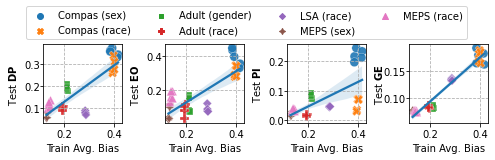

In [94]:
# print (df_res['dataset'].unique())

datasets_plot = [
    'compas_sex', 
    'compas_race', 
    'adult_gender', 
    'adult_race', 
    # 'bank_age', 
    # 'bank_marital=married', 
    # 'lsa_gender',
    'lsa_race',
    'meps_SEX',
    'meps_RACE',
]

df_res = pd.read_csv(f"./res_cache/att_dataset.csv")

# only keep dataset within the datasets_plot
df_res_plot = df_res[df_res['dataset'].isin(datasets_plot)]
# df_res_plot

# sns.scatterplot(data=df_res_plot, x='pred_unf', y='dp', hue='dataset', style='dataset')
# plt.show()
# sns.scatterplot(data=df_res_plot, x='pred_unf', y='eo', hue='dataset', style='dataset')
# plt.show()
# sns.scatterplot(data=df_res_plot, x='pred_unf', y='si', hue='dataset', style='dataset')
# plt.show()
# sns.scatterplot(data=df_res_plot, x='pred_unf', y='ge', hue='dataset', style='dataset')
# plt.show()

fig, axs = plt.subplots(1, 4, figsize=(7, 1.8))

scatterplt_kwargs = {
    's': 80, 'alpha': 0.9, 'linewidth': 0.3, 'hue': 'dataset', 'style': 'dataset',
}

ax = axs[0]
sns.regplot(data=df_res_plot, x='pred_unf', y='dp', scatter=False, ax=ax)
sns.scatterplot(data=df_res_plot, x='pred_unf', y='dp', ax=ax, **scatterplt_kwargs)
ax.set(
    xlabel='Train Avg. Bias',
    # ylabel=r'Demographic Parity $\mathbf{(DP)}$',
    ylabel='Test $\mathbf{DP}$',
)
ax.grid(True, linestyle='--')
ax.legend().set_visible(False)

ax = axs[1]
sns.regplot(data=df_res_plot, x='pred_unf', y='eo', scatter=False, ax=ax)
sns.scatterplot(data=df_res_plot, x='pred_unf', y='eo', ax=ax, **scatterplt_kwargs, legend=False)
ax.set(
    xlabel='Train Avg. Bias',
    # ylabel=r'Equalized Odds $\mathbf{(EO)}$',
    ylabel='Test $\mathbf{EO}$',
)
ax.grid(True, linestyle='--')

ax = axs[2]
sns.regplot(data=df_res_plot, x='pred_unf', y='si', scatter=False, ax=ax)
sns.scatterplot(data=df_res_plot, x='pred_unf', y='si', ax=ax, **scatterplt_kwargs, legend=False)
ax.set(
    xlabel='Train Avg. Bias',
    # ylabel=r'Pred. Inconsistency $\mathbf{(PI)}$',
    ylabel='Test $\mathbf{PI}$',
)
ax.grid(True, linestyle='--')


ax = axs[3]
sns.regplot(data=df_res_plot, x='pred_unf', y='ge', scatter=False, ax=ax)
sns.scatterplot(data=df_res_plot, x='pred_unf', y='ge', ax=ax, **scatterplt_kwargs, legend=False)
ax.set(
    xlabel='Train Avg. Bias',
    # ylabel=r'Generalized Entropy $\mathbf{(GE)}$',
    ylabel='Test $\mathbf{GE}$',
)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Round y-tick labels to 2 decimal places
ax.grid(True, linestyle='--')

# Get the legend handles
handles, labels = axs[0].get_legend_handles_labels()
labels_map = {
    'compas_sex': 'Compas (sex)',
    'compas_race': 'Compas (race)',
    'adult_gender': 'Adult (gender)',
    'adult_race': 'Adult (race)',
    'lsa_race': 'LSA (race)',
    'meps_SEX': 'MEPS (sex)',
    'meps_RACE': 'MEPS (race)',
}
labels = [labels_map[l] for l in labels]
legend = fig.legend(
    handles, labels,
    ncol=4,
    # title='Method',
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.25), 
    fancybox=True, shadow=False, 
)

for ax in axs:
    ytick_labels = ax.get_yticklabels()
    for label in ytick_labels:
        label.set_x(0.05)
    xtick_labels = ax.get_xticklabels()
    for label in xtick_labels:
        label.set_y(0.02)
    ax.yaxis.set_label_coords(-0.3,0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.55, hspace=0.2)
plt.savefig(f'./figs/att_dataset_full.png', bbox_inches='tight', pad_inches=.02, dpi=300)
plt.show()

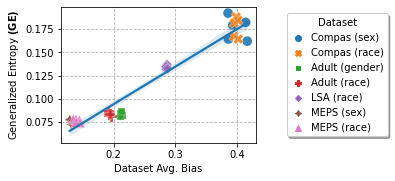

In [224]:
plt.figure(figsize=(3.5, 2.5))

ax = sns.regplot(data=df_res_plot, x='pred_unf', y='ge', scatter=False)
sns.scatterplot(
    data=df_res_plot, x='pred_unf', y='ge', hue='dataset', style='dataset', 
    s=100, 
    alpha=0.9, 
    # edgecolor='k',
    linewidth=0.3,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
labels_map = {
    'compas_sex': 'Compas (sex)',
    'compas_race': 'Compas (race)',
    'adult_gender': 'Adult (gender)',
    'adult_race': 'Adult (race)',
    'lsa_race': 'LSA (race)',
    'meps_SEX': 'MEPS (sex)',
    'meps_RACE': 'MEPS (race)',
}
labels = [labels_map[l] for l in labels]
# Modify the legend to have 3 columns
ax.legend(
    handles, labels, 
    title='Dataset',
    ncol=1,
    columnspacing=0.5, labelspacing=0.5,
    loc='center right', bbox_to_anchor=(1.7, 0.5),
    handlelength=1.5, handletextpad=0.5,
    fancybox=True, shadow=True
)

ax.set(
    xlabel='Dataset Avg. Bias',
    ylabel=r'Generalized Entropy $\mathbf{(GE)}$',
)
ax.grid(True, linestyle='--')

# plt.tight_layout()
plt.savefig(f'./figs/att_dataset.png', bbox_inches='tight', pad_inches=.02, dpi=300)
plt.show()

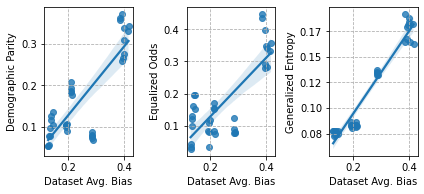

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.8))

sns.regplot(data=df_res_plot, x='pred_unf', y='dp', ax=axs[0])
axs[0].set(
    xlabel='Dataset Avg. Bias',
    ylabel='Demographic Parity',
)
axs[0].set(
    xlabel='Dataset Avg. Bias',
    ylabel='Demographic Parity',
)
axs[0].grid(True, linestyle='--')


sns.regplot(data=df_res_plot, x='pred_unf', y='eo', ax=axs[1])
axs[1].set(
    xlabel='Dataset Avg. Bias',
    ylabel='Equalized Odds',
)
axs[1].grid(True, linestyle='--')

sns.regplot(data=df_res_plot, x='pred_unf', y='ge', ax=axs[2])
axs[2].set(
    xlabel='Dataset Avg. Bias',
    ylabel='Generalized Entropy',
)
axs[2].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Round y-tick labels to 2 decimal places
axs[2].grid(True, linestyle='--')


plt.tight_layout()
plt.savefig(f'./figs/AIM_unfair_pred.pdf', bbox_inches='tight', pad_inches=.02, dpi=300)
plt.show()